In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [3]:
xr.set_options(display_style='text') 

# Functions, data

In [4]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [5]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [6]:
def add_text(ax):
    ax.text(0.1, 0.1,'EAST (upstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")
    ax.text(0.9, 0.1,'WEST (downstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")

In [7]:
def rad_cooling(sim):
    mSWUPT = (sim.ACSWUPT.isel(Time = -1)-sim.ACSWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = -1)-sim.ACSWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = -1)-sim.ACSWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = -1)-sim.ACSWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = -1)-sim.ACLWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = -1)-sim.ACLWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = -1)-sim.ACLWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = -1)-sim.ACLWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB

In [8]:
#hrchannel03_300 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3mps.3km/")


In [9]:
%%time
hrchannel10_300 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/")
hrchannel10_302 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/")

CPU times: user 10.1 s, sys: 4.19 s, total: 14.3 s
Wall time: 12.8 s


In [10]:
hrchannel10_300_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannel10_302_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/')

In [10]:
hrhgt = hrchannel10_300.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3
def plothrsection():
    fig, ax = plt.subplots(1,1,figsize=(15,4))
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot(hrdist,hrhgt,color='k')
    return ax,ax.twinx()

In [3]:
from wrf import cape_2d
import wrf
from netCDF4 import Dataset
from joblib import Parallel, delayed

def compute_individual_cape(file):
    return wrf.getvar(Dataset(file), "cape_2d", timeidx=wrf.ALL_TIMES)

In [4]:
%%time
#Takes 1 hour
for file in sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/wrfout*'))[11:]:
    print(file)
    c = compute_individual_cape(file)
    del(c.attrs['projection'])
    c.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.cape.'+file[-19:]+'.nc')
    

/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/wrfout_d01_1970-04-11_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/wrfout_d01_1970-04-21_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/wrfout_d01_1970-05-01_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/wrfout_d01_1970-05-11_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/wrfout_d01_1970-05-21_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/wrfout_d01_1970-05-31_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/wrfout_d01_1970-06-10_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/wrfout_d01_1970-06-20_06_00_00
/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/wrfout_d01_1970-06-30_06_00_00
/

In [22]:

hrchannel10_300_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d
hrchannel10_302_capecin =xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d




# Lon-lev cross sections

## W

In [22]:
%%time
#hr10_300w = hrchannel10_300.isel(Time=slice(200,801)).W.mean(["Time","south_north"])
hr10_300w = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc")
hr10_300w_plot=hr10_300w.assign_coords({'distance_from_mtn':(1635-hr10_300w.west_east)*3,'eta_level':hrchannel10_300.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()


CPU times: user 18.7 ms, sys: 0 ns, total: 18.7 ms
Wall time: 98.5 ms


Text(0.5, 1.0, 'Moist, high res simulation - W (nonlinear scale) - u=10m/s - SST=300K')

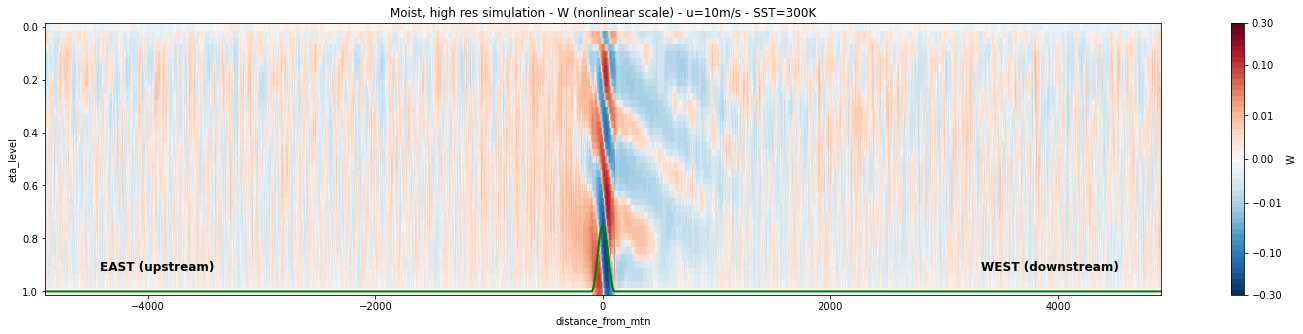

In [23]:
_,ax=plt.subplots(1,1,figsize=(25,5))
hr10_300w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hr10_300w_plot.distance_from_mtn, 1-hrhgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Moist, high res simulation - W (nonlinear scale) - u=10m/s - SST=300K")


In [12]:
%%time
hr10_302w = hrchannel10_302.W.isel(Time=slice(200,801)).mean(["Time","south_north"])
hr10_302w_plot=hr10_302w.assign_coords({'distance_from_mtn':(1635-hr10_302w.west_east)*3,'eta_level':hrchannel10_302.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()


CPU times: user 25.9 s, sys: 53.8 s, total: 1min 19s
Wall time: 49.8 s


In [13]:
hr10_302w.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.W.days50-200.nc")


In [1]:
print(1)

1


Text(0.5, 1.0, 'Moist, high res simulation - W (nonlinear scale) - u=10m/s - SST=302K')

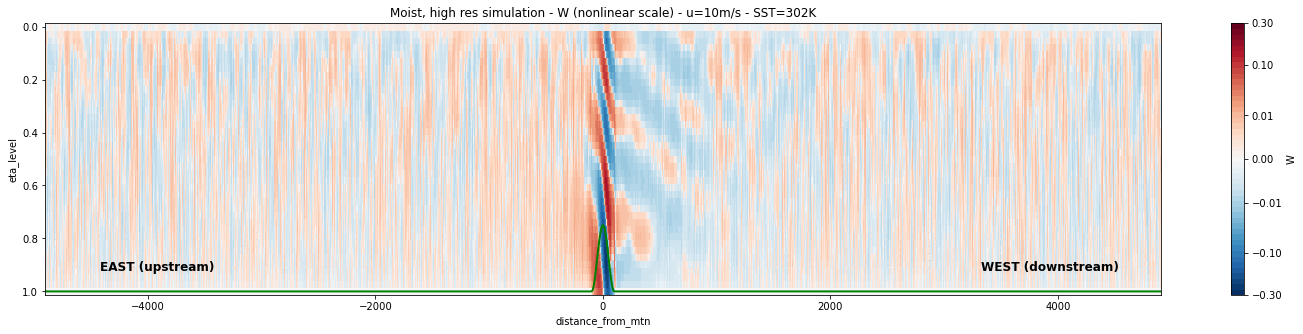

In [24]:
_,ax=plt.subplots(1,1,figsize=(25,5))
hr10_302w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hr10_302w_plot.distance_from_mtn, 1-hrhgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Moist, high res simulation - W (nonlinear scale) - u=10m/s - SST=302K")


Text(0.5, 1.0, '302K-300K')

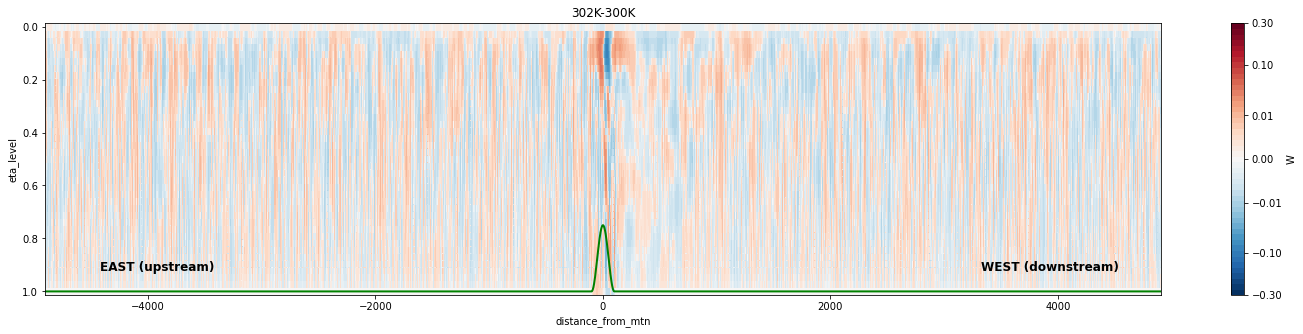

In [52]:
_,ax=plt.subplots(1,1,figsize=(25,5))
(hr10_302w_plot-hr10_300w_plot).plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hr10_302w_plot.distance_from_mtn, 1-hrhgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("302K-300K")


In [140]:
hr10_302qc = hrchannel10_302.QCLOUD.isel(Time=slice(200,1000)).mean(["Time","south_north"])
hr10_302qc_plot=hr10_302qc.assign_coords({'distance_from_mtn':(1635-hr10_302qc.west_east)*3,'eta_level':hrchannel10_302.ZNU.isel(Time=-1)}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()


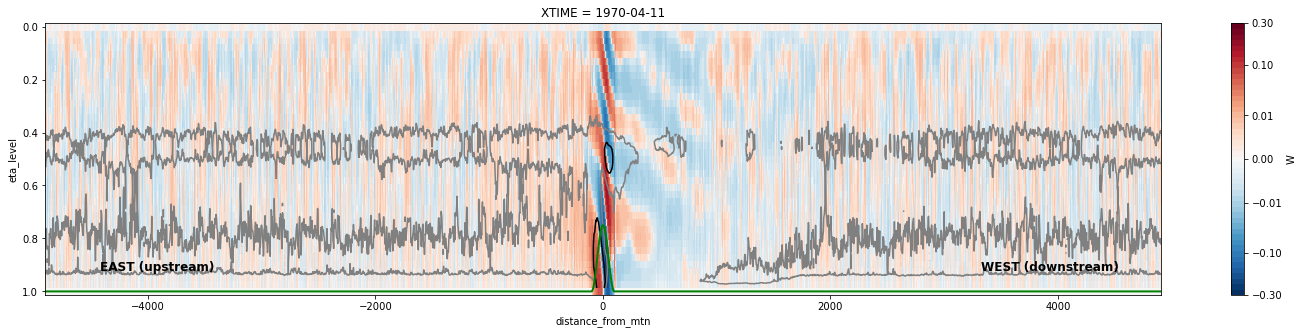

In [146]:
_,ax=plt.subplots(1,1,figsize=(25,5))
hr10_302w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hr10_302w_plot.distance_from_mtn, 1-hrhgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Moist, high res simulation - W (nonlinear scale) - u=10m/s - SST=302K")

hr10_302qc_plot.plot.contour(ax=ax, x='distance_from_mtn',yincrease=False,**{'levels':[1e-5,5e-5],'colors':['gray','k']})
    


## Precip,Cape

In [6]:
hrchannel10_300precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc")
hrchannel10_302precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.precip.days0-100.nc")


In [7]:
p2 = hrchannel10_302precip.isel(Time=slice(200,801)).mean(['south_north','Time']).max()
p0 = hrchannel10_300precip.isel(Time=slice(200,801)).mean(['south_north','Time']).max()

print(np.array(p2/p0-1)/2*100)

2.4784708627019536


In [ ]:
%%time
hrchannel10_302precip = 4*(hrchannel10_302.RAINC+hrchannel10_302.RAINNC).diff('Time').persist()
hrchannel10_302precip.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.precip.days0-200.nc")


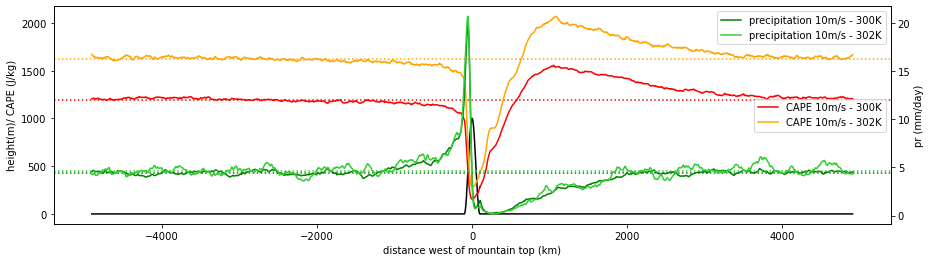

In [29]:
ax,ax2=plothrsection()
ax.set_ylabel("height(m)/ CAPE (J/kg)")

ax.plot(hrdist,hrchannel10_300_capecin[0].mean(['south_north','Time']),color='r',label='CAPE 10m/s - 300K')
ax.axhline(hrchannel10_300_capecin[0].isel(west_east=slice(2000,3000)).mean(),color='r',linestyle=':')

ax.plot(hrdist,hrchannel10_302_capecin[0].mean(['south_north','Time']),color='orange',label='CAPE 10m/s - 302K')
ax.axhline(hrchannel10_302_capecin[0].isel(west_east=slice(2000,3000)).mean(),color='orange',linestyle=':')

ax2.set_ylabel("pr (mm/day)")

ax2.plot(hrdist,hrchannel10_300precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='green',label='precipitation 10m/s - 300K')
ax2.axhline(hrchannel10_300precip.isel(Time=slice(200,801),west_east=slice(2000,3000)).mean(),color='g',linestyle=':')

ax2.plot(hrdist,hrchannel10_302precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='limegreen',label='precipitation 10m/s - 302K')
ax2.axhline(hrchannel10_302precip.isel(Time=slice(200,801),west_east=slice(2000,3000)).mean(),color='limegreen',linestyle=':')


ax.legend(loc="center right")
ax2.legend()


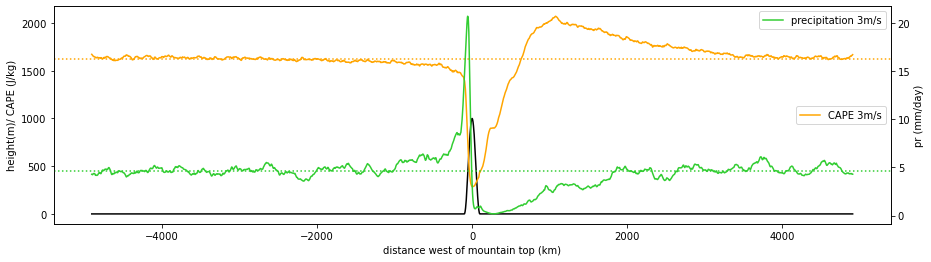

In [28]:
ax,ax2=plothrsection()
ax.set_ylabel("height(m)/ CAPE (J/kg)")

ax.plot(hrdist,hrchannel10_302_capecin[0].mean(['south_north','Time']),color='orange',label='CAPE 10m/s - 302K')
ax.axhline(hrchannel10_302_capecin[0].isel(west_east=slice(2000,3000)).mean(),color='orange',linestyle=':')

ax2.set_ylabel("pr (mm/day)")

ax2.plot(hrdist,hrchannel10_302precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='limegreen',label='precipitation 10m/s - 302K')
ax2.axhline(hrchannel10_302precip.isel(Time=slice(200,801),west_east=slice(2000,3000)).mean(),color='limegreen',linestyle=':')


ax.legend(loc="center right")
ax2.legend()


In [25]:
print(hrchannel10_300precip.isel(Time=slice(400,801)).mean())
print(hrchannel10_300precip.isel(Time=slice(400,801),west_east=slice(2000,3000)).mean())


<xarray.DataArray ()>
array(4.279517, dtype=float32)
<xarray.DataArray ()>
array(4.465766, dtype=float32)


In [23]:
print(hrchannel10_302precip.isel(Time=slice(200,401)).mean())
print(hrchannel10_302precip.isel(Time=slice(200,401),west_east=slice(2000,3000)).mean())


<xarray.DataArray ()>
array(4.460529, dtype=float32)
<xarray.DataArray ()>
array(4.644009, dtype=float32)


## Fractional changes

In [16]:
# Precip
print("Fractional change in upstream region : %.1f %%"%(100*(1-hrchannel10_300precip.isel(Time=slice(200,801),west_east=slice(2000,3000)).mean()/
             hrchannel10_302precip.isel(Time=slice(200,401),west_east=slice(2000,3000)).mean()
          ))
     )

print("Fractional change over mountain : %.1f %%"%(100*(1-hrchannel10_300precip.isel(Time=slice(200,801),west_east=slice(1600,1700)).mean()/
             hrchannel10_302precip.isel(Time=slice(200,401),west_east=slice(1600,1700)).mean()
          ))
     )

print("Fractional change in whole domain : %.1f %%"%(100*(1-hrchannel10_300precip.isel(Time=slice(200,801)).mean()/
             hrchannel10_302precip.isel(Time=slice(200,401)).mean()
          ))
     )

Fractional change in upstream region : 4.7 %
Fractional change over mountain : 2.8 %
Fractional change in whole domain : 4.6 %


In [17]:
# CAPE
print("Fractional change in upstream region : %.1f %%"%(100*(1-hrchannel10_300_capecin[0].isel(Time=slice(200,801),west_east=slice(2000,3000)).mean()/
             hrchannel10_302_capecin[0].isel(Time=slice(200,401),west_east=slice(2000,3000)).mean()
          ))
     )

print("Fractional change over mountain : %.1f %%"%(100*(1-hrchannel10_300_capecin[0].isel(Time=slice(200,801),west_east=slice(1600,1700)).mean()/
             hrchannel10_302_capecin[0].isel(Time=slice(200,401),west_east=slice(1600,1700)).mean()
          ))
     )

print("Fractional change in whole domain : %.1f %%"%(100*(1-hrchannel10_300_capecin[0].isel(Time=slice(200,801)).mean()/
             hrchannel10_302_capecin[0].isel(Time=slice(200,401)).mean()
          ))
     )

Fractional change in upstream region : 22.5 %
Fractional change over mountain : 23.7 %
Fractional change in whole domain : 21.5 %


# Soundings

## W soundings

In [53]:
hr10_302_upstream = hr10_302w_plot.sel(distance_from_mtn=slice(-500,-2000)).mean('distance_from_mtn')
hr10_302_allbutmtn = (hr10_302w_plot.sel(distance_from_mtn=slice(4800,3000)).mean('distance_from_mtn')+hr10_302w_plot.sel(distance_from_mtn=slice(-2000,-4900)).mean('distance_from_mtn'))/2
hr10_302_mtn = hr10_302w_plot.sel(distance_from_mtn=slice(500,-500)).mean('distance_from_mtn')

In [54]:
hr10_300_upstream = hr10_300w_plot.sel(distance_from_mtn=slice(-500,-2000)).mean('distance_from_mtn')
hr10_300_allbutmtn = (hr10_300w_plot.sel(distance_from_mtn=slice(4800,3000)).mean('distance_from_mtn')+hr10_300w_plot.sel(distance_from_mtn=slice(-2000,-4900)).mean('distance_from_mtn'))/2
hr10_300_mtn = hr10_300w_plot.sel(distance_from_mtn=slice(500,-500)).mean('distance_from_mtn')

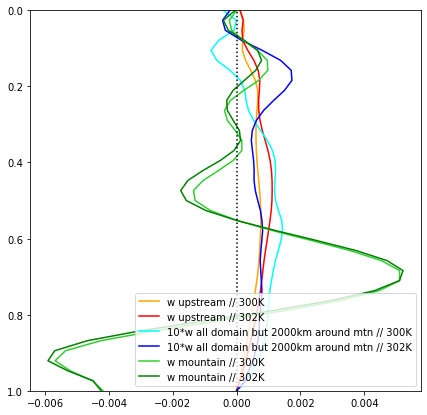

In [57]:
_,ax=plt.subplots(1,1,figsize=(7,7))
ax.plot(hr10_300_upstream,hr10_300_upstream.eta_level, label="w upstream // 300K",color="orange")
ax.plot(hr10_302_upstream,hr10_302_upstream.eta_level, label="w upstream // 302K",color="red")
ax.plot(10*hr10_300_allbutmtn,hr10_300_allbutmtn.eta_level, label="10*w all domain but 2000km around mtn // 300K",color="cyan")
ax.plot(10*hr10_302_allbutmtn,hr10_302_allbutmtn.eta_level, label="10*w all domain but 2000km around mtn // 302K",color="blue")
ax.plot(hr10_300_mtn,hr10_300_mtn.eta_level, label="w mountain // 300K",color="limegreen")
ax.plot(hr10_302_mtn,hr10_302_mtn.eta_level, label="w mountain // 302K",color="green")
ax.legend()
ax.set_ylim(1,0)
ax.axvline(0,linestyle='dotted',color='k')

## Skew-Ts

In [58]:
plevs=np.array([100000,97500,95000,92500,90000,87500,85000,82500,80000,77500,75000,70000,65000,60000,55000,50000,45000,40000,35000,30000,25000,22500,20000,17500,15000,12500,10000,7000,5000,1000])/100


In [59]:
qmean_300 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean_300 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
qmean_300 = qmean_300.where(qmean_300 >0.)  
tmean_300 = tmean_300.where(tmean_300 >100.)  

In [60]:
qmean_302 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.Q_PL.days50-100.nc')
tmean_302 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.T_PL.days50-100.nc')
qmean_302 = qmean_302.where(qmean_302 >0.)  
tmean_302 = tmean_302.where(tmean_302 >100.)  

In [ ]:
def plot_skewt(T,q,plevs,skew,color,lbl):
    P = plevs* units.hPa
    i=0
    Tups = units.degK*np.array(T)
    qups = np.array(q)

    #P=P[::-1]
    #Tups=Tups[::-1]
    #qups=qups[::-1]

    skew.plot(P, Tups,color=color ,label=lbl)
    
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    #Calculate full parcel profile and add to plot as black line
    
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
    profups = mpcalc.parcel_profile(P, Tups[0], Tdups[0]).to('degC')
    skew.plot(P, profups, color=color, linewidth=2)
    skew.shade_cape(P, Tups, profups,color=color)

    skew.plot(P, Tdups,color=color ,label=lbl)
    
fig = plt.figure(figsize=(10,7))
skew = SkewT(fig, rotation=45)

s,lbl=(-4900,-1000),"300K"
plot_skewt(tmean_300.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],qmean_300.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],plevs[1:-4],skew,"orange",lbl)
s,lbl=(-4900,-1000),"302K"
plot_skewt(tmean_302.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],qmean_302.isel(west_east=slice(1635-s[1]//3,1635-s[0]//3)).mean("west_east")[1:-4],plevs[1:-4],skew,"red",lbl)


skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 50)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
plt.legend()
#fig.suptitle(title + " || upstream CAPE = %.1f J/kg, downstream = %.1f J/kg"%(mpcalc.cape_cin(P, Tups, Tdups,profups)[0]/units("J/kg"),mpcalc.cape_cin(P, Tdws, Tddws,profdws)[0]/units("J/kg")),fontsize=20)


# Hovmöllers & Time series

CPU times: user 412 ms, sys: 3.29 s, total: 3.7 s
Wall time: 8.49 s


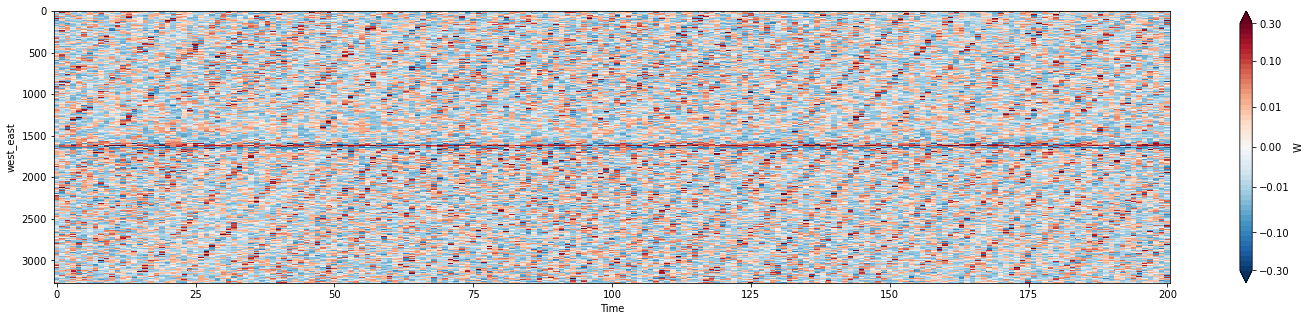

In [64]:
%%time
_,ax=plt.subplots(1,1,figsize=(25,5))
w302_hovmoeller = hrchannel10_302.W.isel(Time=slice(200,401),bottom_top_stag=15).mean(["south_north"])
w302_hovmoeller.plot(ax=ax, x='Time',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})

CPU times: user 1.22 s, sys: 12.6 s, total: 13.8 s
Wall time: 35 s


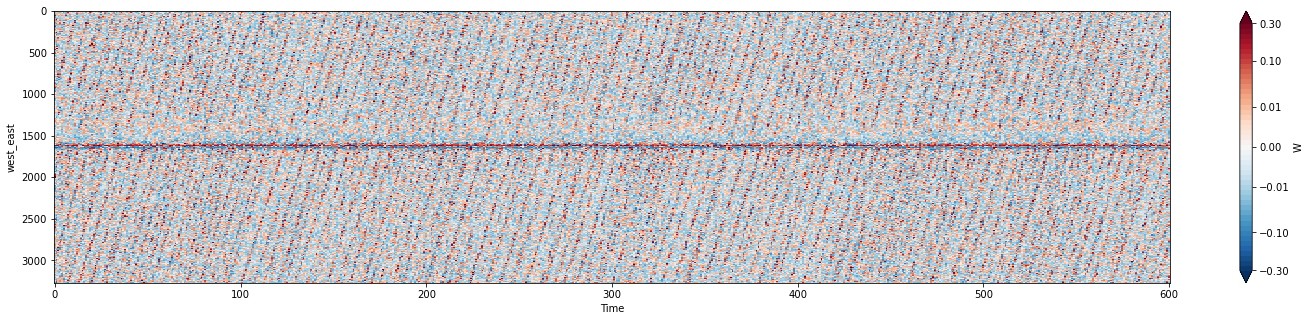

In [72]:
%%time
_,ax=plt.subplots(1,1,figsize=(25,5))
w300_hovmoeller = hrchannel10_300.W.isel(Time=slice(200,801),bottom_top_stag=15).mean(["south_north"])
w300_hovmoeller.plot(ax=ax, x='Time',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})

CPU times: user 708 ms, sys: 54.1 s, total: 54.8 s
Wall time: 1min 15s


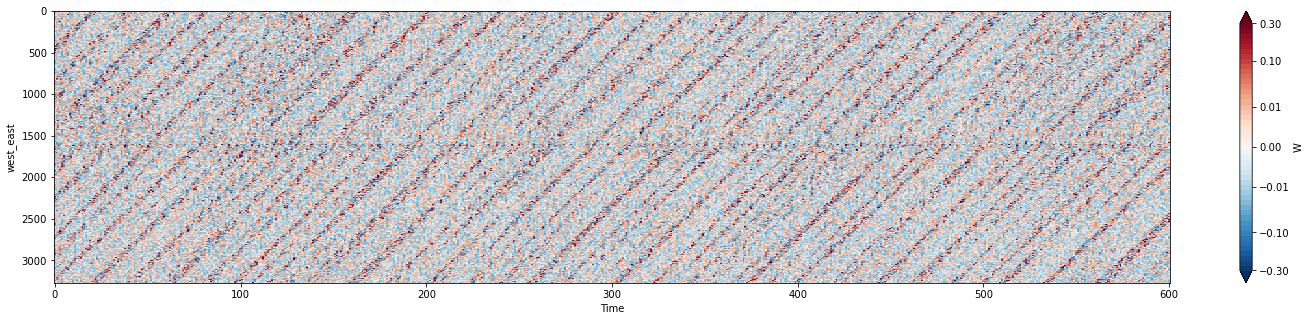

In [73]:
%%time
_,ax=plt.subplots(1,1,figsize=(25,5))
w300_3mps_hovmoeller = hrchannel03_300.W.isel(Time=slice(200,801),bottom_top_stag=15).mean(["south_north"])
w300_3mps_hovmoeller.plot(ax=ax, x='Time',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})

In [74]:
hrchannel10_300precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc")

CPU times: user 753 ms, sys: 1.14 s, total: 1.9 s
Wall time: 2.5 s


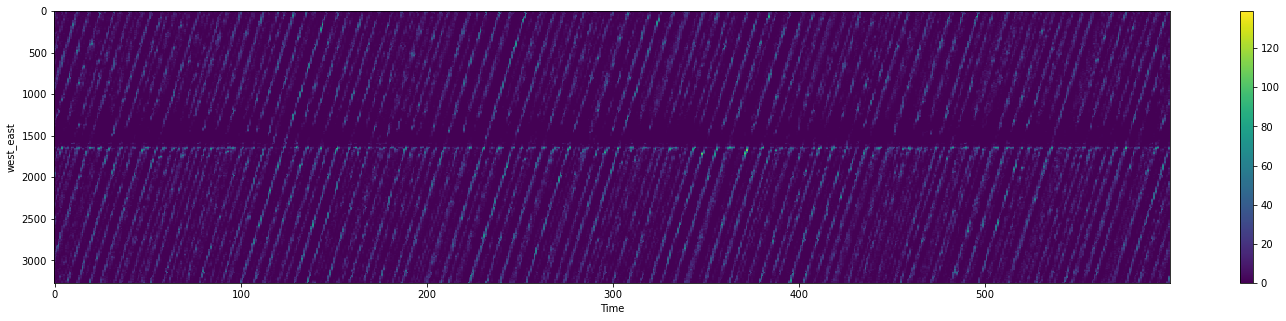

In [76]:
%%time
_,ax=plt.subplots(1,1,figsize=(25,5))
pr300_hovmoeller = hrchannel10_300precip.isel(Time=slice(200,800)).mean(["south_north"])
pr300_hovmoeller.plot(ax=ax, x='Time',yincrease=False)

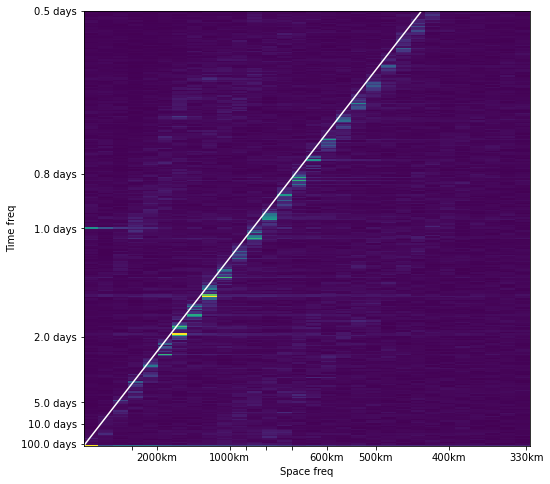

In [159]:
_,ax=plt.subplots(1,1,figsize=(8,8))
pr300_hovmoeller_fft=np.abs(np.fft.fft2(np.array(pr300_hovmoeller)))
ax.pcolormesh(pr300_hovmoeller_fft[:300,:30],vmin=0,vmax=2e6)
ax.set_xlabel("Space freq")
ax.set_ylabel("Time freq")

xtickslabs=np.array([330,400,500,600,700,800,900,1000,2000,3000])
ax.set_xticks(3270*3/xtickslabs)
xtickslabs=['%ikm'%x for x in xtickslabs]
for i in [4,5,6,-1]:
    xtickslabs[i] =''
ax.set_xticklabels(xtickslabs)

ytickslabs=np.array([0.5,0.8,1,2,5,10,100])
ax.set_yticks(600/4/ytickslabs)
ytickslabs=['%.1f days'%x for x in ytickslabs]
ax.set_yticklabels(ytickslabs);None

ax.plot(1/(10*150*86400/(3*3270e3))*np.arange(300),np.arange(300),color='w')

In [156]:
430e3/(0.5*86400)

9.953703703703704

CPU times: user 88.3 ms, sys: 115 ms, total: 203 ms
Wall time: 200 ms


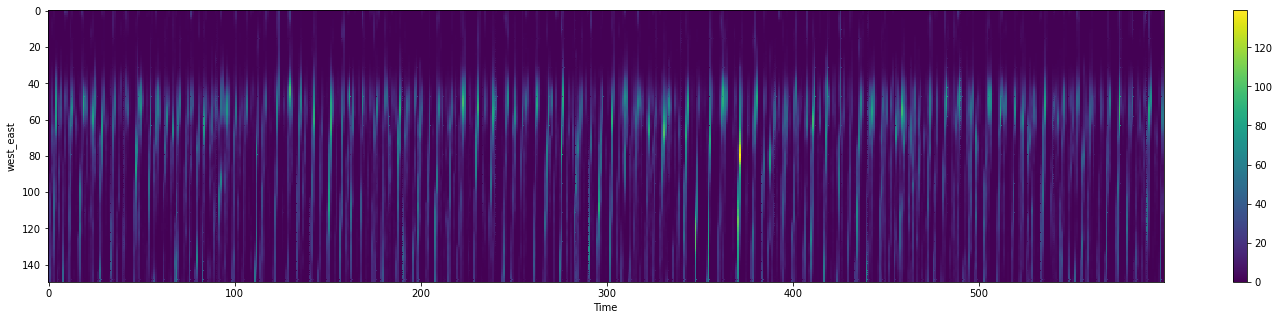

In [131]:
%%time
_,ax=plt.subplots(1,1,figsize=(25,5))
pr300_hovmoeller_mtn = hrchannel10_300precip.isel(Time=slice(200,800),west_east=slice(1600,1750)).mean(["south_north"])
pr300_hovmoeller_mtn.plot(ax=ax, x='Time',yincrease=False)

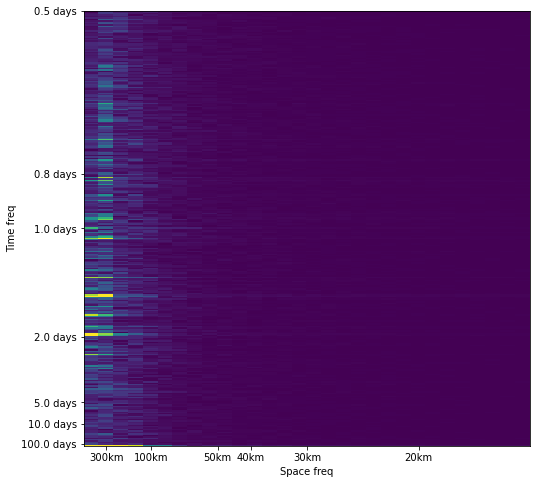

In [138]:
_,ax=plt.subplots(1,1,figsize=(8,8))
pr300_hovmoeller_mtn_fft=np.abs(np.fft.fft2(np.array(pr300_hovmoeller_mtn)))
ax.pcolormesh(pr300_hovmoeller_mtn_fft[:300,:30],vmin=0,vmax=1e5)
ax.set_xlabel("Space freq")
ax.set_ylabel("Time freq")

xtickslabs=np.array([20,30,40,50,100,300])
ax.set_xticks(150*3/xtickslabs)
xtickslabs=['%ikm'%x for x in xtickslabs]
#for i in [4,5,6,-1]:
#    xtickslabs[i] =''
ax.set_xticklabels(xtickslabs)

ytickslabs=np.array([0.5,0.8,1,2,5,10,100])
ax.set_yticks(600/4/ytickslabs)
ytickslabs=['%.1f days'%x for x in ytickslabs]
ax.set_yticklabels(ytickslabs);None

# Analytical theory

In [20]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[0]]-pressure[idxs[-1]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [19]:
from scipy.integrate import cumtrapz
def A_npy(T,p):
    """T temperature in Kelvin, p in pascal. p must be increasing"""
    assert p[0]<p[1]
    L = 2.26e6
    Cp=1004.
    Rv = 461.
    gamma = L*qsat(T,p/100.)/Rv/T**2 * L/Cp
    kappa=2/7
    bl = np.where(p>95000.)[0]
    freetrop = np.where(p<=95000.)[0]
    integ = 1/(1+gamma[freetrop])*np.exp(kappa*cumtrapz(1/(1+gamma[freetrop][::-1]),np.log(p[freetrop][::-1]),initial=0))[::-1]
    a = np.concatenate([integ,integ[-1]*(p[bl]/p[freetrop][-1])**kappa])
    return  a

def A_npy2(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,a,[np.nan]*(n-1-idxs[-1])])
def A(T,p):
    return xr.apply_ufunc(A_npy2,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)
    

def Aplus_npy(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,-cumtrapz(a[::-1],np.log(p[::-1]),initial=0)[::-1],[np.nan]*(n-1-idxs[-1])])

def Omega_npy(T,p):
    aplus=Aplus_npy(T,p)
    aplushat = np.trapz(aplus,p)/(p[-1]-p[0])
    return cumtrapz(aplus[::-1]-aplushat,p[::-1],initial=0)[::-1]

def Aplus(T,p):
    return xr.apply_ufunc(Aplus_npy,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)
    

def Omega(T,p):
    aplus=Aplus(T,p)
    aplushat = pressure_mean(aplus)
    return xr.apply_ufunc(lambda ap,aph,pp : cumtrapz(ap[::-1]-aph,pp[::-1],initial=0)[::-1],
                          aplus,aplushat,p,input_core_dims=[['pressure'],[],['pressure']],output_core_dims=[['pressure']],vectorize=True)

def M(Z,q,T,p):
    Lv = 2.26e6
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    Mq = - pressure_mean(aplus*Lv*q)       + pressure_mean(aplus)*pressure_mean(Lv*q)
    Ms =   pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)
    return Ms-Mq,Ms,Mq

def Mss(Z,T,p):
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    return pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)


In [29]:
qmean_300 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean_300 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
zmean     = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.GHT_PL.days50-100.nc')

qmean_302 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.Q_PL.days50-100.nc')
tmean_302 = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.302K.3km/diags/wrf.T_PL.days50-100.nc')

zmean     = zmean.where(zmean >=0.)  
qmean_300 = qmean_300.where(qmean_300 >0.)  
tmean_300 = tmean_300.where(tmean_300 >100.)
qmean_302 = qmean_302.where(qmean_302 >0.)  
tmean_302 = tmean_302.where(tmean_302 >100.)  

plevs = hrchannel10_300_p.P_PL[0].load()

In [39]:
def change_pcoord(ds):
    ds = ds.assign_coords({'pressure':plevs}).swap_dims({'num_press_levels_stag':'pressure'}).persist()
    return ds.reindex(pressure=list(reversed(ds.pressure)))

In [40]:
%%time
Mh,Ms,Mq = M(change_pcoord(zmean),
             change_pcoord(qmean_300),
             change_pcoord(tmean_300),
             change_pcoord(plevs)
            )




CPU times: user 962 ms, sys: 28 ms, total: 990 ms
Wall time: 1.01 s


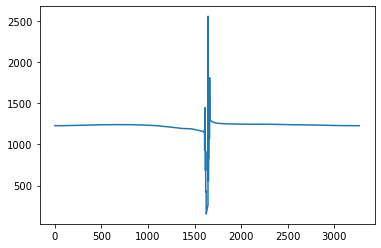

In [48]:
plt.plot(Ms)
